# Multi-Classification Modeling with top 7 beacons with DNN
## Index
- Load data & import modules
- Preprocessing & split
- DNN modeling
- Ploting 
- Cofusion Matrix


# Load data & import moduels
- tensorflow version 2.9.1 required

In [ ]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%cd drive/MyDrive/BEST/ios_clf_direction

/content/drive/MyDrive/BEST/ios_clf_direction


In [ ]:
datas = [] 
data_name = [('S', [1,2,3,4,5,6,7,8,9]), ('E', [1,2,3]), ('R',[1,2,3,4,5]), ('H', [1,2]), ('A', [1,2,3,4,5,6,7,8,9,10,11]), ('U', [1]) ]

for data in data_name:
  for index in data[1]: 
    if index < 10:
      no_supervised = pd.DataFrame(pd.read_csv(f'ios_clf_data_7_direction{data[0]}0{index}.csv'))
    else:
      no_supervised = pd.DataFrame(pd.read_csv(f'ios_clf_data_7_direction{data[0]}{index}.csv'))
    no_supervised = no_supervised.drop('heading', axis=1)
    no_supervised = no_supervised.drop('direction', axis=1)
    datas.append(no_supervised)

In [ ]:
!pip install wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pathlib

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [ ]:
print(tf.__version__)

2.8.2


In [ ]:
# labelEncoder = LabelEncoder()
# for data in datas:
#   data['direction'] = labelEncoder.fit_transform(data['direction'])

# Preprocessing & split
- Concat all the data
- split into 7:3

In [ ]:
result = pd.concat(datas)

In [ ]:
result.drop('Unnamed: 0', axis=1, inplace=True)

# DNN modeling
- Multi-Classification with Top 7 beacons


# Hyperparameter Tuning
- Normalization : Weight Normalization
- learning rate : [0.01, 0.001, 0.0001]
- loss: categorical_crossentropy
- Optimaization: Adam
- epoch: 50
- output layer: 31
- activation: Relu
- activation: Softmax

# Result
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 224 and the optimal learning rate for the optimizer
is 0.001.
- loss: 0.2331
- accuracy: 0.9321 
- precision_1: 0.9347 
- recall_1: 0.9304 
- f1_score: 0.9305 
- 995ms/epoch - 7ms/step

In [ ]:
np.set_printoptions(precision=2)
le = LabelEncoder()

X = np.array(result.iloc[:, 1:])
y = le.fit_transform(np.array(result['location']).reshape(-1, 1))
y = to_categorical(y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42,shuffle=True)

In [ ]:
X_train.shape

(11012, 22)

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 6.6 MB/s 


In [ ]:
import tensorflow_addons as tfa

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
!pip install IPython
import IPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
checkpoint_path = "training_3/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# callback to save the weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
tf.random.set_seed(42)
initializer = tf.keras.initializers.HeNormal()

def model_builder(hp):
   model = keras.Sequential()
    
   hp_unit = hp.Int('units', min_value=32, max_value=256, step=32)
   model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(units=hp_unit, activation = tf.keras.activations.relu, input_shape=[22], kernel_initializer=initializer)))
   model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(units=hp_unit, activation = tf.keras.activations.relu, input_shape=[22], kernel_initializer=initializer)))
   model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(units=hp_unit, activation = tf.keras.activations.relu, input_shape=[22], kernel_initializer=initializer)))
   model.add(keras.layers.Dense(31, activation = 'softmax'))

   # learning rate = [0.01, 0.001, 0.0001]
   hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

   opt = keras.optimizers.Adam(learning_rate=hp_learning_rate)
   loss = tf.keras.losses.categorical_crossentropy
   model.compile(optimizer= opt, loss=loss, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=31, average='macro', threshold=0.5)])


   return model

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 135 kB 7.3 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 30,
                     factor=3,
                     hyperband_iterations=2,
                     directory = 'hi',
                     project_name = 'ios_clf_6')

INFO:tensorflow:Reloading Oracle from existing project hi/ios_clf_6/oracle.json
INFO:tensorflow:Reloading Tuner from hi/ios_clf_6/tuner0.json


In [ ]:
tuner.search(X_train, y_train, epochs = 50, validation_data = (X_test, y_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 224 and the optimal learning rate for the optimizer
is 0.0001.



In [ ]:
model_based_tuner = tuner.hypermodel.build(best_hps)
history = model_based_tuner.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_train,y_train), callbacks= [ClearTrainingOutput()])

Epoch 1/50
345/345 [==============================] - 9s 16ms/step - loss: 1.3692 - accuracy: 0.5850 - precision_1: 0.8407 - recall_1: 0.3119 - f1_score: 0.4014 - val_loss: 0.8135 - val_accuracy: 0.6851 - val_precision_1: 0.8357 - val_recall_1: 0.5746 - val_f1_score: 0.6084
Epoch 2/50
345/345 [==============================] - 4s 11ms/step - loss: 0.7396 - accuracy: 0.7181 - precision_1: 0.8358 - recall_1: 0.5770 - f1_score: 0.6318 - val_loss: 0.6879 - val_accuracy: 0.7288 - val_precision_1: 0.8393 - val_recall_1: 0.6014 - val_f1_score: 0.6405
Epoch 3/50
345/345 [==============================] - 4s 12ms/step - loss: 0.6513 - accuracy: 0.7530 - precision_1: 0.8476 - recall_1: 0.6306 - f1_score: 0.6868 - val_loss: 0.6067 - val_accuracy: 0.7902 - val_precision_1: 0.8689 - val_recall_1: 0.6151 - val_f1_score: 0.6623
Epoch 4/50
345/345 [==============================] - 4s 12ms/step - loss: 0.5880 - accuracy: 0.7880 - precision_1: 0.8554 - recall_1: 0.6685 - f1_score: 0.7213 - val_loss: 0.

In [ ]:
model_based_tuner_dict = history.history
model_based_tuner_dict.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'val_f1_score'])

In [ ]:
results = model_based_tuner.evaluate(X_test,  y_test, verbose=2)

148/148 - 0s - loss: 0.1471 - accuracy: 0.9553 - precision_1: 0.9564 - recall_1: 0.9528 - f1_score: 0.9517 - 277ms/epoch - 2ms/step


# Ploting 

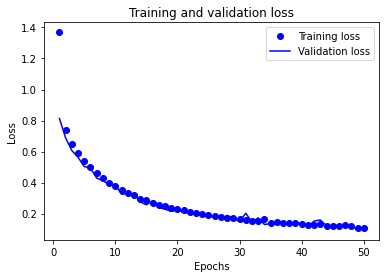

In [ ]:
acc = model_based_tuner_dict['accuracy']
val_acc = model_based_tuner_dict['val_accuracy']
loss = model_based_tuner_dict['loss']
val_loss = model_based_tuner_dict['val_loss']
recall = model_based_tuner_dict['recall_1']
val_recall = model_based_tuner_dict['val_recall_1']
f1_score = model_based_tuner_dict['f1_score']
val_f1_score = model_based_tuner_dict['val_f1_score']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

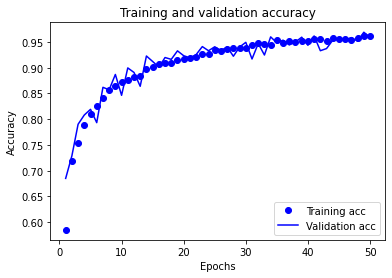

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

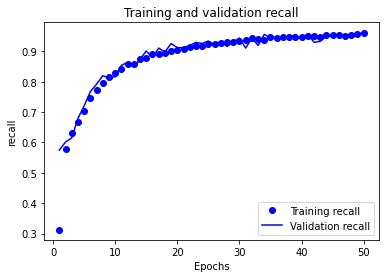

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()

plt.show()

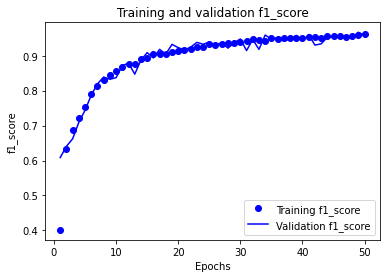

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, f1_score, 'bo', label='Training f1_score')
plt.plot(epochs, val_f1_score, 'b', label='Validation f1_score')
plt.title('Training and validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend()

plt.show()

# Confusion Matrix

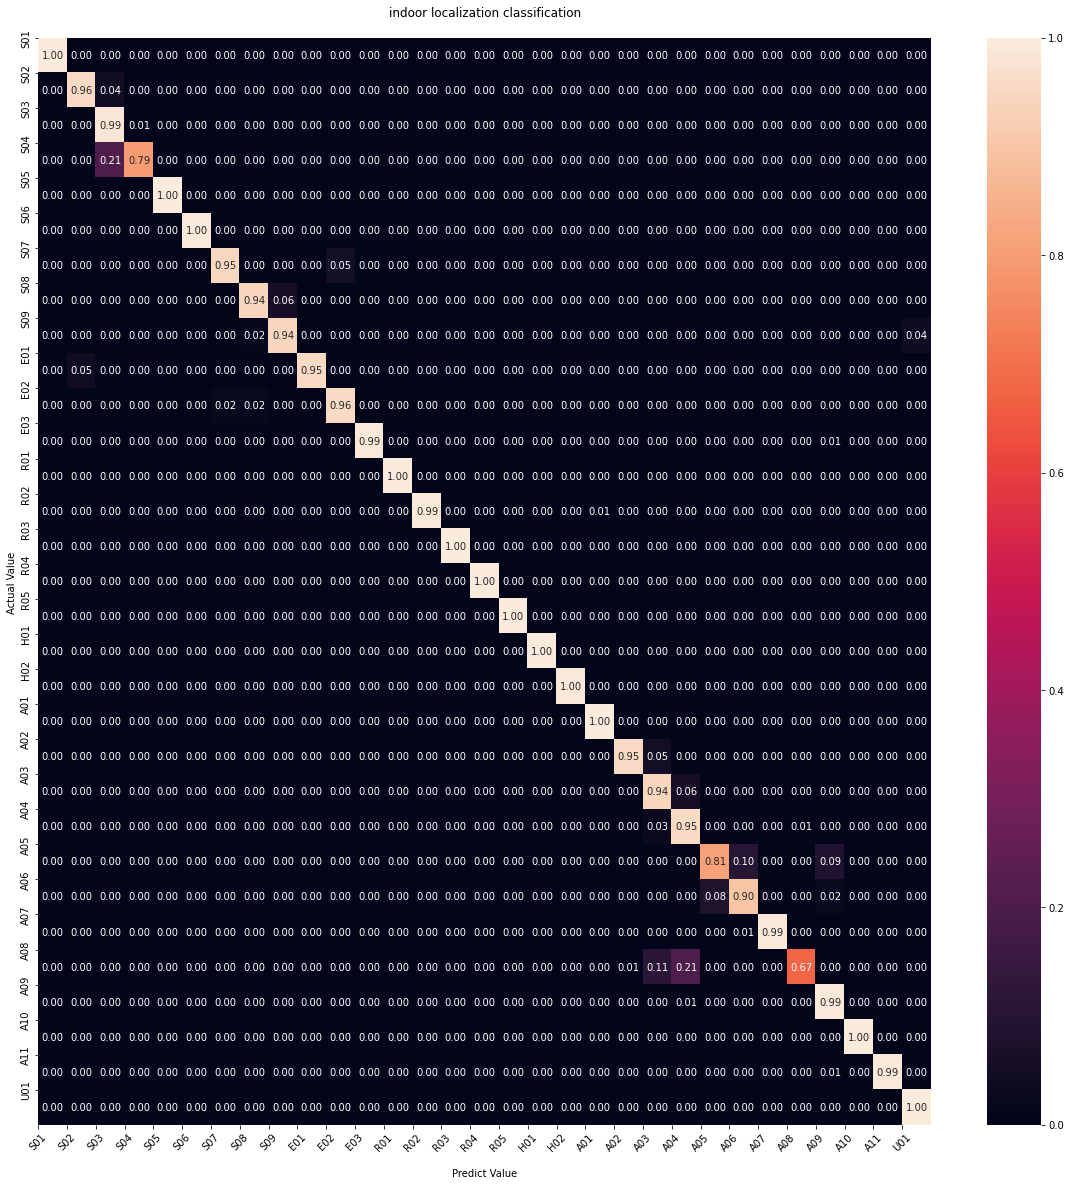

In [ ]:
labels = ['S01','S02','S03','S04','S05','S06','S07','S08','S09','E01','E02','E03','R01','R02','R03','R04','R05','H01','H02','A01','A02','A03','A04','A05','A06','A07','A08','A09','A10','A11','U01']

from sklearn.metrics import confusion_matrix
y_test_arg=np.argmax(y,axis=1)
y_test_arg = le.inverse_transform(y_test_arg)
Y_pred = np.argmax(model_based_tuner.predict(X),axis=1)
Y_pred = le.inverse_transform(Y_pred)

tick_marks = np.arange(len(labels))
cf_matrix = confusion_matrix(y_test_arg, Y_pred, labels=y_ticks)
cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20)) 
ax = sns.heatmap(cmn, annot = True, fmt='.2f')
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
ax.set_title('indoor localization classification\n')
ax.set_xlabel('\nPredict Value')
ax.set_ylabel('Actual Value ')
plt.show()

In [ ]:


# # Convert the model.
# converter = tf.lite.TFLiteConverter.from_keras_model(model_based_tuner)
# tflite_model = converter.convert()

# # Save the model.
# with open('ios_clf_NN_model_for_beacon7.tflite', 'wb') as f:
#   f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmplrcw434z/assets


INFO:tensorflow:Assets written to: /tmp/tmplrcw434z/assets


# Test Data

In [ ]:
testdatas = [] 
data_name = [('S', [1,2,3,4,5,6,7,8,9]), ('E', [1,2,3]), ('R',[1,2,3,4,5]), ('H', [1,2]), ('A', [1,2,3,4,5,6,7,8,9,10,11]), ('U', [1]) ]

#Filtered_Test_U01

for data in data_name:
  for index in data[1]: 
    if index < 10:
      no_supervised = pd.DataFrame(pd.read_csv(f'../test_data/Filtered_Test_{data[0]}0{index}.csv'))
      no_supervised.drop('direction', axis=1, inplace=True)
      no_supervised.drop('timeStamp', axis=1, inplace=True)
      no_supervised.drop('heading', axis=1, inplace=True)
      no_supervised.insert(0, 'location' ,f'{data[0]}0{index}')
    else:
      no_supervised = pd.DataFrame(pd.read_csv(f'../test_data/Filtered_Test_{data[0]}{index}.csv'))
      no_supervised.drop('direction', axis=1, inplace=True)
      no_supervised.drop('heading', axis=1, inplace=True)
      no_supervised.drop('timeStamp', axis=1, inplace=True)
      no_supervised.insert(0, 'location' ,f'{data[0]}{index}')
    testdatas.append(no_supervised)


def tominus200(x) :
  if float(x) <= -90 :
    return -200
  return float(x)

beacons = ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016','017','018','019','020','021', '022']
for data in testdatas:
  for beacon in beacons:
    data[beacon] = data[beacon].apply(tominus200)

In [ ]:
for data in testdatas:
  for row_index in range(len(data)):
    if row_index % 2 == 1:
      for col_index in range(1, len(data.columns)):
        if data.iloc[row_index - 1, col_index] > data.iloc[row_index, col_index]:
          data.iloc[row_index, col_index] = data.iloc[row_index - 1, col_index]


In [ ]:
# 상위 7개를 통해서 classification 하기
for data in testdatas:
  for row_index in range(len(data)):
    column_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
    a = sorted(data.loc[row_index].tolist()[1:])
    b = list(a)[-7:]
    isMax = [0]
    for i in range(len(data.columns)):
      for num in b:
        if data.loc[row_index][i] == num:
          isMax.append(i)

    remove_set = set(isMax)
    column_idx = [i for i in column_idx if i not in remove_set]
    data.iloc[[row_index], column_idx] = [-200 for i in range(len(column_idx))]
  

In [ ]:
for index in range(len(testdatas)):
  testdatas[index] = testdatas[index].iloc[1::2,:]

for index in range(len(testdatas)):
  testdatas[index].reset_index(inplace=True)

for index in range(len(testdatas)):
  testdatas[index].drop('index', axis=1, inplace=True)

result_test = pd.concat(testdatas)
result_test.reset_index(inplace=True)
result_test.drop('index', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
np.set_printoptions(precision=2)
le = LabelEncoder()

X = np.array(result_test.iloc[:, 1:])
y = le.fit_transform(np.array(result_test['location']).reshape(-1, 1))
y = to_categorical(y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


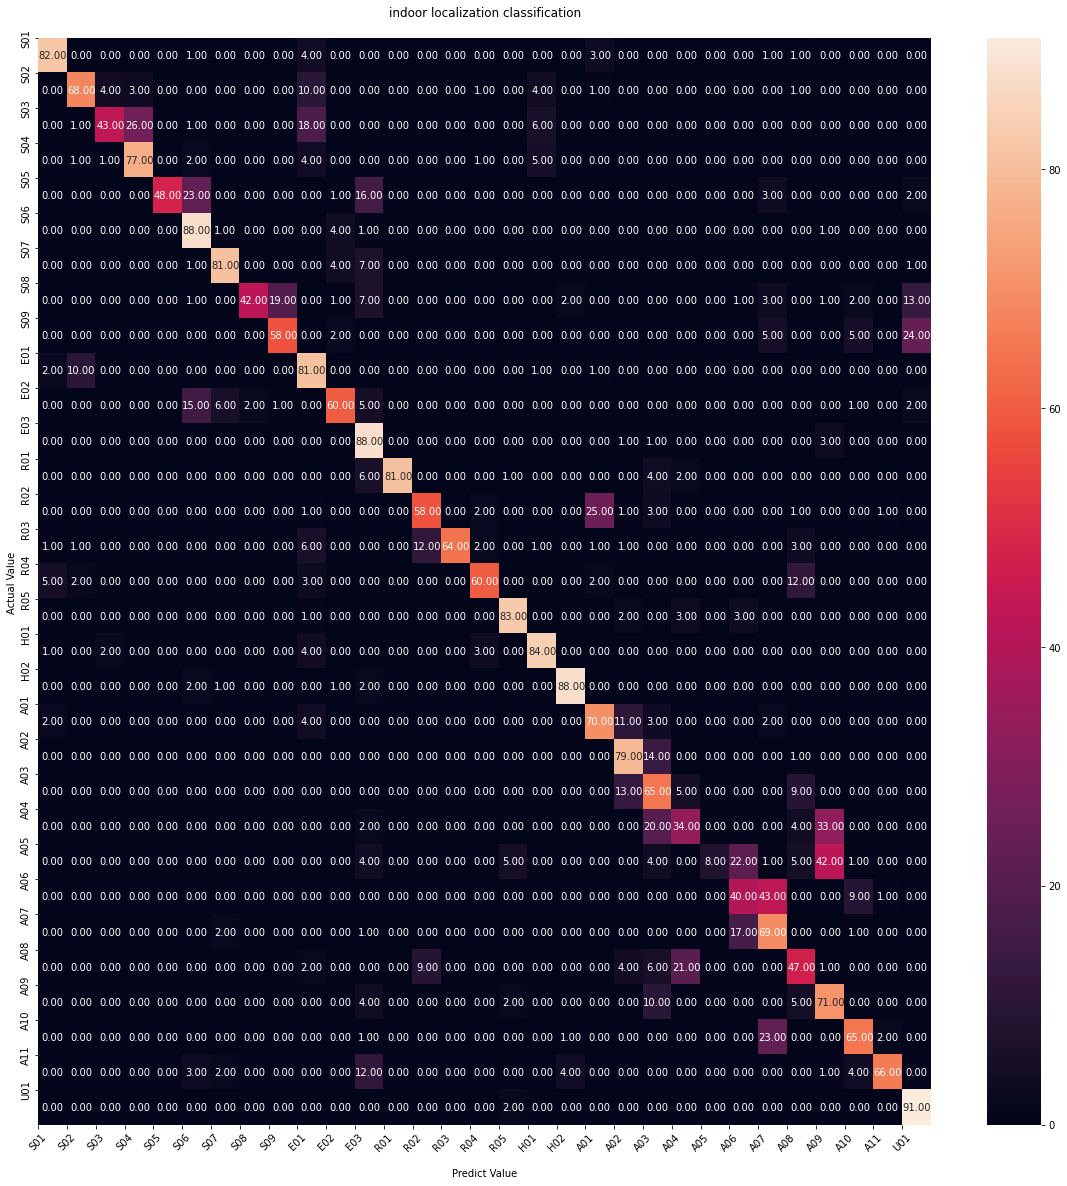

In [ ]:
from sklearn.metrics import confusion_matrix

labels = ['S01','S02', 'S03','S04','S05','S06','S07','S08','S09', 'E01','E02','E03', 'R01', 'R02', 'R03', 'R04',
           'R05', 'H01', 'H02', 'A01', 'A02', 'A03','A04','A05','A06','A07','A08','A09','A10', 'A11', 'U01']
y_test_arg=np.argmax(y,axis=1)
y_test2 = le.inverse_transform(y_test_arg)
Y_pred = np.argmax(model_based_tuner.predict(X),axis=1)
Y_pred2 = le.inverse_transform(Y_pred)

# print(Y_pred)
# print('Confusion Matrix')
tick_marks = np.arange(len(labels))
cf_matrix = confusion_matrix(y_test2, Y_pred2, labels = labels)
cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20)) 
ax = sns.heatmap(cf_matrix, annot = True, fmt='.2f')
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

ax.set_title('indoor localization classification\n')
ax.set_xlabel('\nPredict Value')
ax.set_ylabel('Actual Value ')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("f1score: ", f1_score(y_true=y_test_arg, y_pred=Y_pred, average='weighted'))
print("accuracy: ", accuracy_score(y_true=y_test_arg, y_pred=Y_pred))
print("precision: ", precision_score(y_true=y_test_arg, y_pred=Y_pred, average='weighted'))
print("recall: ", recall_score(y_true=y_test_arg, y_pred=Y_pred,  average='weighted'))

f1score:  0.7036001300093119
accuracy:  0.7116928446771379
precision:  0.7559976418399678
recall:  0.7116928446771379


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test2, Y_pred2, target_names=labels)

In [ ]:
model_based_tuner.save('ios_beacon_DNN_7')

INFO:tensorflow:Assets written to: ios_beacon_DNN_7/assets


INFO:tensorflow:Assets written to: ios_beacon_DNN_7/assets
